In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.opt_utils import *
import h5py
import pickle
from qutip import *
import time
import tqdm
from scipy.optimize import minimize, basinhopping, brute

In [2]:
wc_A = 4.069814 * (10**9) * 2 * np.pi  # cavity A frequency
wc_B = 6.096062 * (10**9) * 2 * np.pi  # cavity A frequency
wa =  5.325 * (10**9) * 2 * np.pi  # atom frequency
dt_A = np.abs(wc_A - wa) / (2 * np.pi)
dt_B = np.abs(wc_B - wa) / (2 * np.pi)
chi_A = 0.00215 * (10**9) * 2 * np.pi
chi_B = 0.00544 * (10**9) * 2 * np.pi
g_A = np.sqrt(chi_A * dt_A) * 2 * np.pi  # coupling strength w/ cavity A
g_B = np.sqrt(chi_B * dt_B) * 2 * np.pi  # coupling strength w/ cavity B

gamma = 333333.333        # atom dissipation rate
kappa_A = 10000       # cavity A dissipation rate
kappa_B = 10000       # cavity B dissipation rate

temp_q = 0.01        # avg number of thermal bath excitation for qubit
temp_A = 0.04        # avg number of thermal bath excitation for cavity A
temp_B = 0.05        # avg number of thermal bath excitation for cavity B

In [3]:
cavity_dims = 8

def cost_g(final_expect, final_state):
    return  np.power(np.abs(final_state[0][0]), 2)

def cost_q_e(final_expect, final_state):
    return  np.power(np.abs(final_state[cavity_dims]), 2)

def cost_qA_g1(final_expect, final_state):
    return np.power(np.abs(final_state[1][0]), 2)

def cost_qAB_g1(final_expect, final_state):
    return np.power(np.abs(final_state[cavity_dims][0]), 2)

def cost_qAB_g11_dm(final_expect, final_state):
    return np.power(np.abs(final_state[cavity_dims + 1][0]), 2)

In [4]:
max_segs = 20
us = 0.000001
time_start = 0 * us
time_stop = 2 * us
init_amp = 4000000
n_steps = 501

N_pts = 201

num_drives = 2
num_cavities = 1
# cavity_dims = 8
state_sizes = [2, cavity_dims]
state_vals = [0, 0]
sim_options = Options()
element_freqs = [wa, wc_A]
drive_freqs = [wa, wc_A]
drive_elem_nums = [0, 1]
output_cost_func = cost_qA_g1
verbose = False
plot_trial_pulses = False

save_dir = r'C:\Users\Wang_Lab\Documents\GitLab\quantum_control_rl_server\examples\sim_entangle_3E_interp2\save_data'
img_name = time.strftime('%Y%m%d-%H%M%S.png')

t_arr = np.linspace(time_start, time_stop, n_steps)

t_step = (time_stop - time_start) / n_steps

sim_options.store_final_state = True

sm, a_A, a_B, sx, sz = reg_ops(num_cavities + 1, cavity_dims)
element_freqs = np.array(element_freqs)
drive_freqs = np.array(drive_freqs)


gammas = [gamma, kappa_A, kappa_B]
temps = [temp_q, temp_A, temp_B]
c_ops = [] # gen_c_ops(elements, [sm, a_A, a_B, sx, sz], gammas, temps)

# Operators used in Hamiltonian
drive_ops = [sm.dag(), sm, a_A.dag(), a_A]
element_ops = [sz, a_A.dag() * a_A]
H_0 = -(chi_A * a_A.dag() * a_A * sz)
eval_ops = [sm.dag() * sm, a_A.dag() * a_A]

init_state = tensor((basis(state_sizes[0], 0) * np.sqrt(1 - state_vals[0])) + (basis(state_sizes[0], 1) * np.sqrt(state_vals[0])), (basis(state_sizes[1], 0) * np.sqrt(1 - state_vals[1])) + (basis(state_sizes[1], 1) * np.sqrt(state_vals[1])))

In [5]:
client_args = [num_drives, drive_ops, element_freqs, H_0, init_state, eval_ops, sim_options, output_cost_func, time_start, time_stop, drive_freqs, drive_elem_nums,verbose, plot_trial_pulses]

selective_pi_amp = 2091131
selective_pi_sigma = 0.30

In [6]:
def snap_to_cost_eval(opts, *args):
    args = args[0]
    d_amp_1_r = opts[0]
    d_amp_2_r = opts[1]
    d_amp_2_i = opts[2]
    d_time_2 = opts[3]
    
    print(f'Trial parameters: {opts}')
    
    time_start = args[8]
    time_stop = args[9]
    
    qubit_time = (time_start + time_stop) / 2
    qubit_amp = 2 * selective_pi_amp
    
    qubit_func = gauss_gen(qubit_amp, qubit_time, selective_pi_sigma * us, 1)
    
    d_1_func_r = gauss_gen(d_amp_1_r, 0.2 * us, 0.05 * us, 1)
    d_2_func_r = gauss_gen(d_amp_2_r, d_time_2 * us, 0.05 * us, 1)
    d_2_func_i = gauss_gen(d_amp_2_i, d_time_2 * us, 0.05 * us, 1)
    
    drive_amp_funcs = [[qubit_func],
                       [zero],
                       [d_1_func_r, d_2_func_r],
                       [d_2_func_i]]
    
    comp_amp_funcs = [func_sum(np.array(drive_amp_funcs[i])) for i in range(len(drive_amp_funcs))]
    
    t_arr = np.linspace(time_start, time_stop, N_pts)[1:-1]
    
    amp_pts = np.array([[(comp_amp_funcs[i])(t_arr)] for i in range(len(comp_amp_funcs))])
    
    t_pts = np.array([t_arr for i in range(len(amp_pts))])
    
    opts = np.append(amp_pts.flatten(), t_pts.flatten())
    
    res = sim_interp_cost_eval(opts, *args)
    
    print(f'|1g> population: {res}')
    
    return res

In [ ]:
x0=[10000000, 5000000, 1000000, 1.8]

bounds = [[-20000000, 20000000],
          [-20000000, 20000000],
          [-20000000, 20000000],
          [1.5, 1.9]]

res = minimize(snap_to_cost_eval, x0=x0, method='Powell', args=client_args, options={"maxiter": 1000}, bounds=bounds)

C:\Users\Wang_Lab\anaconda3\envs\qcrl-server\lib\site-packages\scipy\optimize\_minimize.py:521: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


Trial parameters: [1.0e+07 5.0e+06 1.0e+06 1.8e+00]


  0%|          | 0/11 [00:00<?, ?it/s]

drive_freqs: [3.34579618e+10 2.55713955e+10 3.83026872e+10 3.34714706e+10]
Trial I time 0: [0.00000000e+00 1.12500000e-07 2.25000000e-07 3.37500000e-07
 4.50000000e-07 5.62500000e-07 6.75000000e-07 7.87500000e-07
 9.00000000e-07 1.01250000e-06 1.12500000e-06 1.23750000e-06
 1.35000000e-06 1.46250000e-06 1.57500000e-06 1.68750000e-06
 1.80000000e-06 1.91250000e-06 2.02500000e-06 2.13750000e-06
 2.25000008e-06]
Trial I amp 0: [0.000000e+00 2.570730e+05 8.645830e+05 2.119068e+06 3.785031e+06
 4.926978e+06 4.673889e+06 3.231192e+06 1.627922e+06 5.977110e+05
 1.599330e+05 3.118700e+04 4.433000e+03 4.600000e+02 3.600000e+01
 3.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00
 0.000000e+00]
Trial Q time 0: [0.00000000e+00 1.12500000e-07 2.25000000e-07 3.37500000e-07
 4.50000000e-07 5.62500000e-07 6.75000000e-07 7.87500000e-07
 9.00000000e-07 1.01250000e-06 1.12500000e-06 1.23750000e-06
 1.35000000e-06 1.46250000e-06 1.57500000e-06 1.68750000e-06
 1.80000000e-06 1.91250000e-06 2.

  9%|▉         | 1/11 [02:23<23:50, 143.02s/it]

final_dm: Quantum object: dims = [[2, 8, 8], [1, 1, 1]], shape = (128, 1), type = ket
Qobj data =
[[-1.05079494e-01-0.16393153j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-9.31612618e-01+0.0064462j ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 2.49250764e-02+0.05329552j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-4.16305343e-02-0.04687259j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 

 18%|█▊        | 2/11 [04:44<21:19, 142.18s/it]

final_dm: Quantum object: dims = [[2, 8, 8], [1, 1, 1]], shape = (128, 1), type = ket
Qobj data =
[[-1.05079494e-01-0.16393153j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-9.31612618e-01+0.0064462j ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 2.49250764e-02+0.05329552j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-4.16305343e-02-0.04687259j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 

 27%|██▋       | 3/11 [07:05<18:54, 141.77s/it]

final_dm: Quantum object: dims = [[2, 8, 8], [1, 1, 1]], shape = (128, 1), type = ket
Qobj data =
[[-1.05079494e-01-0.16393153j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-9.31612618e-01+0.0064462j ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 2.49250764e-02+0.05329552j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-4.16305343e-02-0.04687259j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 

 36%|███▋      | 4/11 [09:29<16:37, 142.53s/it]

final_dm: Quantum object: dims = [[2, 8, 8], [1, 1, 1]], shape = (128, 1), type = ket
Qobj data =
[[-1.05079494e-01-0.16393153j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-9.31612618e-01+0.0064462j ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 2.49250764e-02+0.05329552j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-4.16305343e-02-0.04687259j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 

 45%|████▌     | 5/11 [11:51<14:13, 142.17s/it]

final_dm: Quantum object: dims = [[2, 8, 8], [1, 1, 1]], shape = (128, 1), type = ket
Qobj data =
[[-1.05079494e-01-0.16393153j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-9.31612618e-01+0.0064462j ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 2.49250764e-02+0.05329552j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-4.16305343e-02-0.04687259j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 

 55%|█████▍    | 6/11 [14:14<11:52, 142.59s/it]

final_dm: Quantum object: dims = [[2, 8, 8], [1, 1, 1]], shape = (128, 1), type = ket
Qobj data =
[[-1.05079494e-01-0.16393153j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-9.31612618e-01+0.0064462j ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 2.49250764e-02+0.05329552j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-4.16305343e-02-0.04687259j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 

 64%|██████▎   | 7/11 [16:36<09:29, 142.42s/it]

final_dm: Quantum object: dims = [[2, 8, 8], [1, 1, 1]], shape = (128, 1), type = ket
Qobj data =
[[-1.05079494e-01-0.16393153j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-9.31612618e-01+0.0064462j ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 2.49250764e-02+0.05329552j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-4.16305343e-02-0.04687259j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 

 73%|███████▎  | 8/11 [18:58<07:06, 142.24s/it]

final_dm: Quantum object: dims = [[2, 8, 8], [1, 1, 1]], shape = (128, 1), type = ket
Qobj data =
[[-1.05079494e-01-0.16393153j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-9.31612618e-01+0.0064462j ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 2.49250764e-02+0.05329552j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-4.16305343e-02-0.04687259j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 

 82%|████████▏ | 9/11 [21:21<04:44, 142.36s/it]

final_dm: Quantum object: dims = [[2, 8, 8], [1, 1, 1]], shape = (128, 1), type = ket
Qobj data =
[[-1.05079494e-01-0.16393153j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-9.31612618e-01+0.0064462j ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 2.49250764e-02+0.05329552j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-4.16305343e-02-0.04687259j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 

 91%|█████████ | 10/11 [23:45<02:22, 142.91s/it]

final_dm: Quantum object: dims = [[2, 8, 8], [1, 1, 1]], shape = (128, 1), type = ket
Qobj data =
[[-1.05079494e-01-0.16393153j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-9.31612618e-01+0.0064462j ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 2.49250764e-02+0.05329552j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-4.16305343e-02-0.04687259j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 

100%|██████████| 11/11 [26:06<00:00, 142.41s/it]

final_dm: Quantum object: dims = [[2, 8, 8], [1, 1, 1]], shape = (128, 1), type = ket
Qobj data =
[[-1.05079494e-01-0.16393153j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-9.31612618e-01+0.0064462j ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 2.49250764e-02+0.05329552j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [-4.16305343e-02-0.04687259j]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j        ]
 [ 

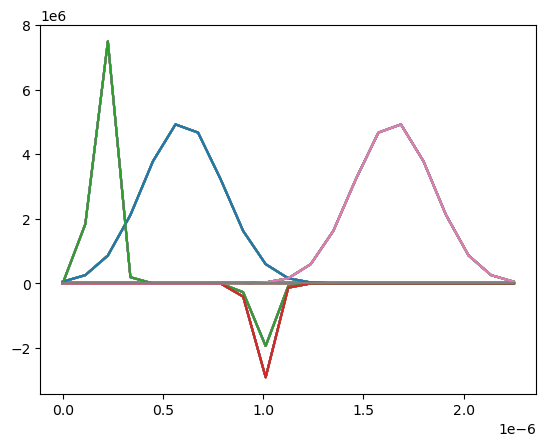

In [58]:
costs = []

for A in tqdm.tqdm(A_arr):
    amp_funcs = [
        [gauss_gen(q1_pi_amp, q1_time, q1_pi_sigma, 1)], 
        [zero], 
        [gauss_gen(A1_pi_amp, A1_time, A1_pi_sigma, 1), gauss_gen(A2_pi_amp, A2_time, A2_pi_sigma, 1)], 
        [gauss_gen(A2_pi_ampi, A2_time, A2_pi_sigma, 1)], 
        [zero], #gauss_gen(B1_pi_amp, B1_time, B1_pi_sigma, 1), gauss_gen(B2_pi_amp, B2_time, B2_pi_sigma, 1)], 
        [zero], # gauss_gen(B2_pi_ampi, B2_time, B2_pi_sigma, 1)],
        [gauss_gen(q2_pi_amp, q2_time, q2_pi_sigma, 1)], 
        [zero]
    ]
    amp_func = [func_sum(amp_funcs[i]) for i in range(len(amp_funcs))]
    amp_pts = np.array([amp_func[i](amp_times) for i in range(len(amp_func))])
    # print(amp_pts)
    
    for i in range(len(amp_func)):
        plt.plot(amp_times, amp_pts[i], label=f'A: {A}, drive: {i}')
    
    client_opts = np.append(np.append(amp_pts[:, 1:-1].flatten(), times[:, 1:-1].flatten()), drive_freqs)
    
    res = sim_interp_cost_eval(client_opts, *client_args)
    costs.append(res[0])
    # print(f'Amp: {A}, cost: {res[0][0]}')
plt.show()

In [36]:
amp_funcs_1g = [
        [gauss_gen(q1_pi_amp, q1_time, q1_pi_sigma, 1)], 
        [zero], 
        [gauss_gen(A1_pi_amp, A1_time, A1_pi_sigma, 1), gauss_gen(A2_pi_amp, A2_time, A2_pi_sigma, 1)], 
        [gauss_gen(A2_pi_ampi, A2_time, A2_pi_sigma, 1)], 
        # [zero], # gauss_gen(B1_pi_amp, B1_time, B1_pi_sigma, 1), gauss_gen(B2_pi_amp, B2_time, B2_pi_sigma, 1)], 
        # [zero], # gauss_gen(B2_pi_ampi, B2_time, B2_pi_sigma, 1)],
        # [gauss_gen(q2_pi_amp, q2_time, q2_pi_sigma, 1)], 
        # [zero]
    ]
amp_func = [func_sum(amp_funcs_1g[i]) for i in range(len(amp_funcs_1g))]
amp_pts = np.array([amp_func[i](amp_times) for i in range(len(amp_func))])

times_1g = times[:len(amp_pts)]

In [37]:
np.savetxt("./opt_SNAP_times_1g.txt", times_1g)
np.savetxt("./opt_SNAP_amps_1g.txt", amp_pts)

In [22]:
print(f'Costs: {costs}')

Costs: [0.07950525568311534, 0.06814796741190972, 0.05855417709134774]


In [15]:
# print(f'Costs: {costs}')

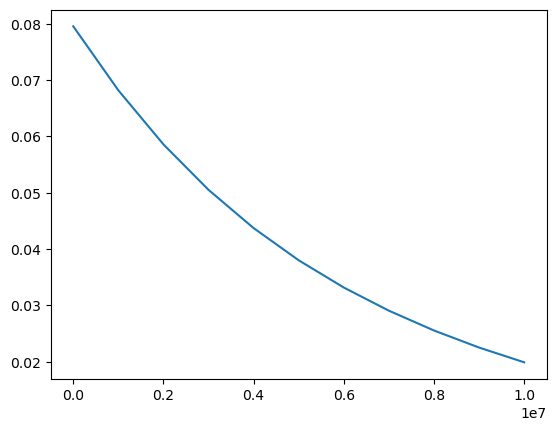

In [32]:
plt.plot(A_arr[:len(costs)], costs)
plt.show()

In [ ]:
print(A_arr[np.argmax(costs)])

In [ ]:
plt.plot(amp_times, gauss_gen(1000000, (time_start + time_stop) / 8, A1_pi_sigma, 1)(amp_times))
plt.show()